# Quadratic Discriminant Analysis (QDA)

## Introduction

Quadratic Discriminant Analysis (QDA) is an extension of Linear Discriminant Analysis (LDA) that allows for different covariance matrices for each class. This results in quadratic decision boundaries between classes, hence the name "Quadratic" Discriminant Analysis.

## Key Difference from LDA

The main distinction between QDA and LDA is:

- LDA assumes all classes share the same covariance matrix $\mathbf{\Sigma}$.
- QDA allows each class to have its own covariance matrix $\mathbf{\Sigma}_r$.

This difference leads to more flexible decision boundaries but requires estimating more parameters.

## Quadratic Discriminant Function

In QDA, the discriminant function for each class $r$ is quadratic in the feature vector $\mathbf{x}$:

$$
d_r(\mathbf{x}) = -\frac{1}{2} \ln \det(\hat{\mathbf{\Sigma}}_r) - \frac{1}{2} (\mathbf{x} - \hat{\boldsymbol{\mu}}_r)^T \hat{\mathbf{\Sigma}}_r^{-1} (\mathbf{x} - \hat{\boldsymbol{\mu}}_r) + \ln \hat{\pi}_r
$$

## QDA Algorithm

Given:
- $N$ training points $\{r_n, \mathbf{x}_n\}$ and $R$ classes
- Laplace smoothing factor $s > 0$

Compute for each class $r = 1, 2, \ldots, R$:

1. Prior probability estimate:
   $$\hat{\pi}_r = \frac{N_r + s}{N + sR}$$

2. Mean vector estimate:
   $$\hat{\boldsymbol{\mu}}_r = \frac{1}{N_r} \sum_{r_n=r} \mathbf{x}_n$$

3. Covariance matrix estimate:
   $$\hat{\mathbf{\Sigma}}_r = \frac{1}{N_r - 1} \sum_{r_n=r} (\mathbf{x}_n - \hat{\boldsymbol{\mu}}_r)(\mathbf{x}_n - \hat{\boldsymbol{\mu}}_r)^T$$

Classify new features $\mathbf{x}$ using:

4. Discriminant function:
   $$d_r(\mathbf{x}) = -\frac{1}{2} \ln \det(\hat{\mathbf{\Sigma}}_r) - \frac{1}{2} (\mathbf{x} - \hat{\boldsymbol{\mu}}_r)^T \hat{\mathbf{\Sigma}}_r^{-1} (\mathbf{x} - \hat{\boldsymbol{\mu}}_r) + \ln \hat{\pi}_r$$

5. Classification rule:
   $$r^*(\mathbf{x}) = \arg\max_{1 \leq r \leq R} d_r(\mathbf{x})$$

## Comparison with LDA

1. Decision Boundaries:
   - LDA: Linear decision boundaries
   - QDA: Quadratic decision boundaries

2. Covariance Matrices:
   - LDA: One shared covariance matrix $\mathbf{\Sigma}$
   - QDA: Separate covariance matrix $\mathbf{\Sigma}_r$ for each class

3. Number of Parameters:
   - LDA: Fewer parameters to estimate
   - QDA: More parameters to estimate (can lead to overfitting with small datasets)

4. Flexibility:
   - LDA: Less flexible, but more robust with small datasets
   - QDA: More flexible, can capture more complex class relationships

## When to Use QDA

QDA is particularly useful when:
- You have enough data to reliably estimate separate covariance matrices for each class.
- The classes have significantly different covariance structures.
- The decision boundaries between classes are likely to be nonlinear.

However, if you have limited data or suspect that the classes have similar covariance structures, LDA might be a better choice due to its simplicity and robustness.

In [1]:
import jax
import jax.numpy as jnp
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array, check_X_y
from sklearn.utils.multiclass import unique_labels
from typing import Tuple

class JAXQDA(BaseEstimator, ClassifierMixin):
    """
    Quadratic Discriminant Analysis (QDA) classifier using JAX for numerical computations.

    Parameters
    ----------
    smoothing : float, default=1.0
        Laplace smoothing factor to be used when estimating the class prior probabilities.

    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        The unique class labels.

    n_classes_ : int
        The number of unique classes.

    n_features_ : int
        The number of features in the input data.

    priors_ : ndarray of shape (n_classes,)
        The estimated class prior probabilities.

    means_ : ndarray of shape (n_classes, n_features)
        The estimated means for each class.

    covariances_ : ndarray of shape (n_classes, n_features, n_features)
        The estimated covariance matrices for each class.
    """
    
    def __init__(self, smoothing: float = 1.0):
        self.smoothing = smoothing

    def fit(self, X: jnp.ndarray, y: jnp.ndarray) -> 'JAXQDA':
        """
        Fit the QDA model according to the given training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]
        
        self.priors_ = self._estimate_priors(y)
        self.means_, self.covariances_ = self._estimate_gaussian_parameters(X, y)
        
        return self
    
    def _estimate_priors(self, y: jnp.ndarray) -> jnp.ndarray:
        """
        Estimate the prior probabilities for each class.

        Parameters
        ----------
        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        priors : ndarray of shape (n_classes,)
            The estimated prior probabilities for each class.
        """
        priors = jnp.zeros(self.n_classes_)
        N = len(y)
        
        for idx, cls in enumerate(self.classes_):
            N_r = jnp.sum(y == cls)
            priors = priors.at[idx].set((N_r + self.smoothing) / (N + self.smoothing * self.n_classes_))
        
        return priors
    
    def _estimate_gaussian_parameters(self, X: jnp.ndarray, y: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Estimate the mean vectors and covariance matrices for each class.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        means : ndarray of shape (n_classes, n_features)
            The estimated mean vectors for each class.

        covariances : ndarray of shape (n_classes, n_features, n_features)
            The estimated covariance matrices for each class.
        """
        means = jnp.zeros((self.n_classes_, self.n_features_))
        covariances = jnp.zeros((self.n_classes_, self.n_features_, self.n_features_))
        
        for idx, cls in enumerate(self.classes_):
            class_features = X[y == cls]
            means = means.at[idx].set(jnp.mean(class_features, axis=0))
            centered_features = class_features - means[idx]
            covariances = covariances.at[idx].set(jnp.dot(centered_features.T, centered_features) / (len(class_features) - 1))
        
        return means, covariances
    
    def _compute_discriminant_functions(self, X: jnp.ndarray) -> jnp.ndarray:
        """
        Compute the discriminant functions for each class.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        discriminants : ndarray of shape (n_samples, n_classes)
            The discriminant function values for each class.
        """
        discriminants = jnp.zeros((X.shape[0], self.n_classes_))
        
        for idx in range(self.n_classes_):
            mean = self.means_[idx]
            cov = self.covariances_[idx]
            inv_cov = jnp.linalg.inv(cov)
            log_det_cov = jnp.log(jnp.linalg.det(cov))
            diff = X - mean
            discriminants = discriminants.at[:, idx].set(
                -0.5 * log_det_cov
                - 0.5 * jnp.einsum('ij,ij->i', jnp.dot(diff, inv_cov), diff)
                + jnp.log(self.priors_[idx])
            )
        
        return discriminants
    
    def predict(self, X: jnp.ndarray) -> jnp.ndarray:
        """
        Perform classification on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted class labels for each data sample.
        """
        X = check_array(X)
        discriminants = self._compute_discriminant_functions(X)
        return self.classes_[jnp.argmax(discriminants, axis=1)]
    
    def predict_proba(self, X: jnp.ndarray) -> jnp.ndarray:
        """
        Estimate class probabilities for input data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data.

        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes)
            Estimated class probabilities for each data sample.
        """
        X = check_array(X)
        discriminants = self._compute_discriminant_functions(X)
        exp_discriminants = jnp.exp(discriminants)
        return exp_discriminants / jnp.sum(exp_discriminants, axis=1, keepdims=True)

# Example usage:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = JAXQDA(smoothing=1.0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print("Predictions:", predictions)
print("Accuracy:", jnp.mean(predictions == y_test))


Predictions: [1 0 2 1 1 0 1 2 2 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]
Accuracy: 0.9666667


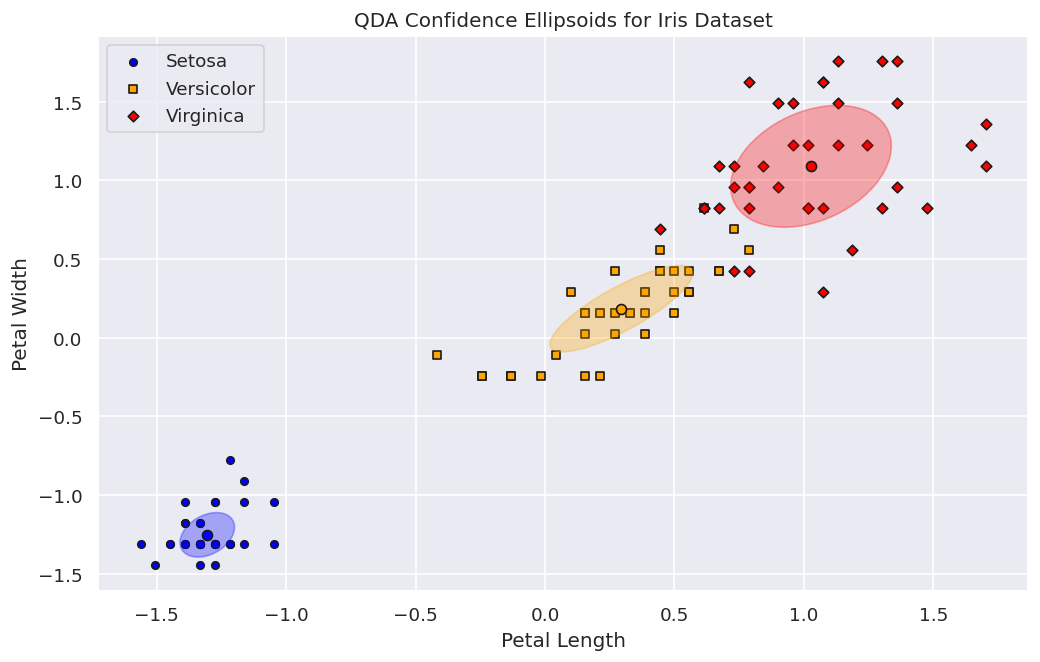

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax.numpy as jnp
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array, check_X_y
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

sns.set_theme()


def plot_confidence_ellipses(ax, means, covariances, colors, labels):
    for mean, cov, color, label in zip(means, covariances, colors, labels):
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigvals)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.3)
        ax.add_patch(ell)
        ax.scatter(mean[0], mean[1], color=color, label=None, edgecolor='k')

# Load the Iris dataset
iris = load_iris()
X = iris.data[:, [2, 3]]  # Use only petal length and petal width
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the JAXQDA model
model = JAXQDA(smoothing=1.0)
model.fit(X_train, y_train)

# Extract the means and covariances
means = model.means_
covariances = model.covariances_

# Plot the decision boundary and decision regions
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# Plot the training points
colors = ['blue', 'orange', 'red']
markers = ['o', 's', 'D']
labels = ['Setosa', 'Versicolor', 'Virginica']

for idx, cls in enumerate(model.classes_):
    ax.scatter(X_train[y_train == cls, 0], X_train[y_train == cls, 1],
               color=colors[idx], label=labels[cls],
               edgecolor='k', s=20, marker=markers[cls])

# Plot the confidence ellipses
plot_confidence_ellipses(ax, means, covariances, colors, iris.target_names)

# Set plot labels and legend
ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.legend(loc='upper left')
ax.set_title('QDA Confidence Ellipsoids for Iris Dataset')

plt.show()

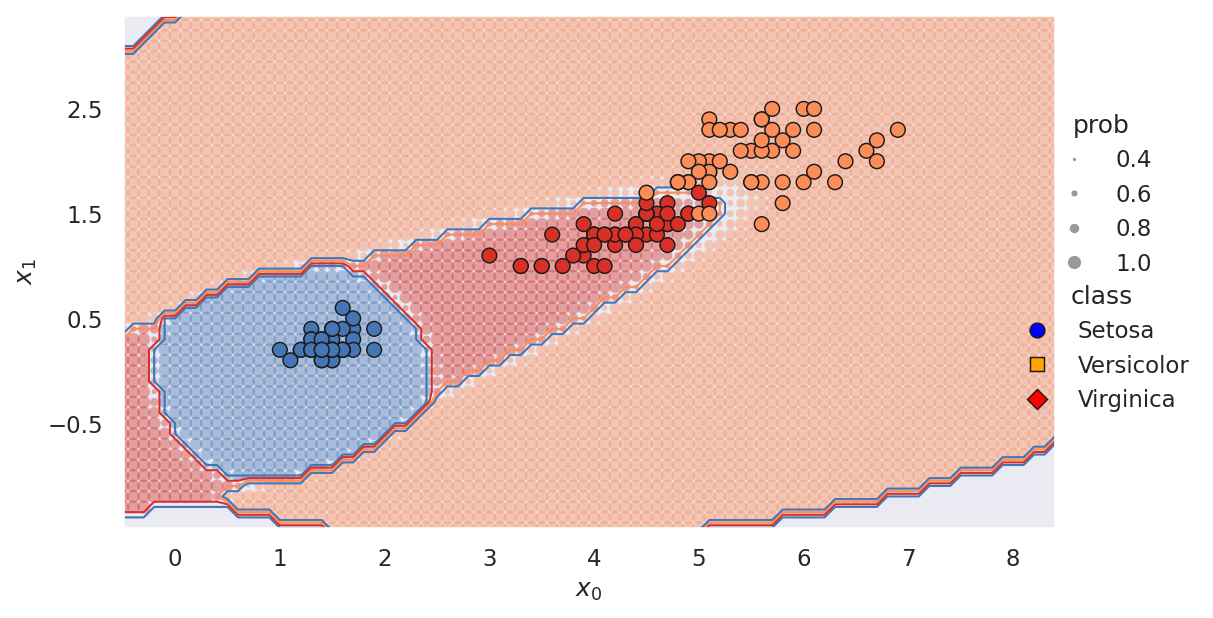

In [15]:
#modify from https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import jax.numpy as jnp

# Assuming your JAXLDA class is already defined

# Load the iris dataset
iris = datasets.load_iris()
x = iris.data[:, [2,3]]  # we only take the first two features
y = iris.target

# Set main parameters
H = 0.1  # mesh stepsize
PROB_DOT_SCALE = 40
PROB_DOT_SCALE_POWER = 3
TRUE_DOT_SIZE = 50
PAD = 1.5

# Create and train the LDA model
model = JAXQDA(smoothing=1.0)
model.fit(jnp.array(x), jnp.array(y))

# Create mesh grid
x0_min, x0_max = np.round(x[:, 0].min()) - PAD, np.round(x[:, 0].max()) + PAD
x1_min, x1_max = np.round(x[:, 1].min()) - PAD, np.round(x[:, 1].max()) + PAD
x0_axis_range = np.arange(x0_min, x0_max, H)
x1_axis_range = np.arange(x1_min, x1_max, H)
xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

# Predict probabilities for the mesh grid
xx = jnp.array(np.c_[xx0.ravel(), xx1.ravel()])
yy_prob = model.predict_proba(xx)
yy_prob = np.array(yy_prob)  # Convert from JAX array to NumPy array
yy_hat = yy_prob.argmax(axis=1)
yy_size = yy_prob.max(axis=1)

# Create plot
sns.set_theme()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=150)

# Define colors
redish = '#d73027'
orangeish = '#fc8d59'
blueish = '#4575b4'
colormap = np.array([blueish, redish, orangeish])

# Plot probability dots
ax.scatter(xx[:, 0], xx[:, 1], c=colormap[yy_hat], alpha=0.4,
           s=PROB_DOT_SCALE * yy_size**PROB_DOT_SCALE_POWER, linewidths=0)

# Plot contours
ax.contour(x0_axis_range, x1_axis_range,
           yy_hat.reshape(xx0.shape),
           levels=3, linewidths=1,
           colors=[blueish, redish, orangeish])

# Plot original data points
ax.scatter(x[:, 0], x[:, 1], c=colormap[y], s=TRUE_DOT_SIZE, zorder=3,
           linewidths=0.7, edgecolor='k')

# Set labels
ax.set_ylabel(r"$x_1$")
ax.set_xlabel(r"$x_0$")

# Create legends
legend_class = []
for flower_class, color, marker in zip(labels, colors, markers):
    legend_class.append(Line2D([0], [0], marker=marker, label=flower_class, ls='None',
                               markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE),
                               markeredgecolor='k', markeredgewidth=0.7))

prob_values = [0.4, 0.6, 0.8, 1.0]
legend_prob = []
for prob in prob_values:
    legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                              markerfacecolor='grey',
                              markersize=np.sqrt(PROB_DOT_SCALE * prob**PROB_DOT_SCALE_POWER),
                              markeredgecolor='k', markeredgewidth=0))

legend1 = ax.legend(handles=legend_class, loc='center',
                    bbox_to_anchor=(1.05, 0.35),
                    frameon=False, title='class')

legend2 = ax.legend(handles=legend_prob, loc='center',
                    bbox_to_anchor=(1.05, 0.65),
                    frameon=False, title='prob')

ax.add_artist(legend1)

# Adjust ticks and grid
ax.set_yticks(np.arange(x1_min, x1_max, 1))
ax.grid(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_aspect(1)
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(np.arange(x1_min, x1_max, 1)[1:])

plt.tight_layout()
plt.show()